Start of modelling

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

C:\Users\hidde\AppData\Local\Temp\ipykernel_12364\2310800911.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# Read datafile
data = pd.read_csv("Complete_dataset.csv")

In [6]:
# Transfer to date variable and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# Replace na with 0
data.fillna(0, inplace=True)

In [51]:
# Create list with names of all variables
all_predictors = data.columns.drop(['RET', 'Month', 'permno'])
# Save the return
y_variable = ['RET']


OLS-3 includes size = 'mvel1', Book-to-Market = 'bm', momentum = 'mom12m' Does it also include 'mom1m','mom6m','mom12m','mom36m'?

In [40]:
# Create Dataset for OLS-3 (Need to determine the momentum variable!)
three_predictors_and_return = ['mvel1', 'bm','mom12m', 'RET']
three_predictors = ['mvel1', 'bm','mom12m']
data3 = data[three_predictors_and_return]

In [8]:
# Look at dataset with only 3 predictors
data3

,mvel1,bm,mom12m,RET
Date,,,,
1957-01-01,1.220639e+07,0.000000,-0.016260,-0.082386
1957-01-01,1.153415e+07,0.000000,0.143456,-0.017021
1957-01-01,1.077829e+07,0.000000,0.012912,0.031364
1957-01-01,8.769161e+06,0.000000,-0.186409,-0.045396
1957-01-01,5.225362e+06,0.000000,0.051821,-0.107884
...,...,...,...,...
2016-12-01,1.022451e+07,-0.000213,0.152332,0.074279
2016-12-01,1.021339e+07,0.544931,0.039258,-0.034056
2016-12-01,1.020248e+07,0.280728,0.171187,-0.028373


In [41]:
# Function that runs OLS with an expending windows
# Input: 
#   data: dataframe, 
#   y_variable: name of y variable
#   X_variable: names of x variables
# Output: list of mse_scores, (access by: expanding_regression_OLS()[0]), and list of r_squared_scores, (access by: expanding_regression_OLS()[1]) 


def expanding_regression_OLS(data, y_variable, x_variables):
    
    mse_scores = []
    r_squared_scores = []
    years = data.index.year.unique()

    for i in range(len(years) - 18 - 12): # i is 0 to the last start_year which is the last year minus the start training years and validation years.
        start_year = years[i]
        end_train_year = start_year + 18  # 18 years of training and increasing with 1 year every iteration
        end_validation_year = end_train_year + 12  # 12 years of validation
        end_test_year = end_validation_year + 1  # 1 year of test

        # Creating data frames for training, validation and testing.
        train_data = data[(data.index.year < end_train_year)]
        #val_data = data[(data.index.year >= end_train_year) & (data.index.year < end_validation_year)]
        test_data = data[(data.index.year >= end_validation_year) & (data.index.year < end_test_year)]

        X_train = train_data[x_variables]
        X_test = test_data[x_variables]
        y_train = train_data[y_variable]
        y_test = test_data[y_variable]
        
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Calculate MSE
        mse = np.mean((y_pred - y_test) ** 2)
        mse_scores.append(mse)

        # Calculate r_squared
        r_squared = model.score(X_test, y_test) 
        r_squared_scores.append(r_squared)
    return mse_scores, r_squared_scores

In [54]:
# Get mean r-squared for OLS-3
r_squared_scores = expanding_regression_OLS(data3, y_variable, three_predictors)[1]
print(np.mean(r_squared_scores)) # -0.027886

-0.027886363618365665


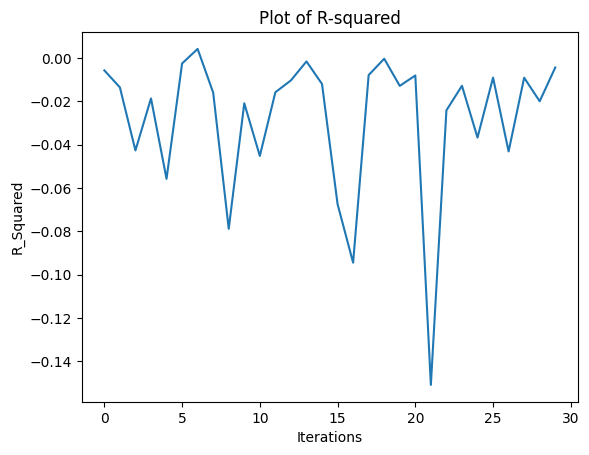

In [55]:
#Plot R-Squared
# Plotting the values
plt.plot(r_squared_scores)

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('R_Squared')
plt.title('Plot of R-squared')

# Display the plot
plt.show()

In [56]:
# Get mean r-squared for full OLS (10m runtime)
# print(f"The mean R-Squared for the full dataset is: {np.mean(expanding_regression_OLS(data, y_variable, all_predictors)[1])}") #-1725.3562


The mean R-Squared for the full dataset is: -17245.35622453705
